## Assignment 1 - Breast Cancer Dataset

##### Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from tabulate import tabulate



##### Loading the dataset and checking for null values

In [5]:
df = pd.read_csv("Breast.csv")

# Display basic info and first few rows
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       285 non-null    int64  
 1   class                    285 non-null    bool   
 2   radiusMean               285 non-null    float64
 3    textureMean             285 non-null    float64
 4    perimeterMean           285 non-null    float64
 5    areaMean                285 non-null    float64
 6    smoothnessMean          285 non-null    float64
 7    compactnessMean         285 non-null    float64
 8    concavityMean           285 non-null    float64
 9    concavePointsMean       285 non-null    float64
 10   symmetryMean            285 non-null    float64
 11   fractalDimensionMean    285 non-null    float64
 12   radiusStdErr            285 non-null    float64
 13   textureStdErr           285 non-null    float64
 14   perimeterStdErr         2

In [6]:
null_values = df.isnull().sum()
print(null_values)
df.isnull().values.any()


ID                         0
class                      0
radiusMean                 0
 textureMean               0
 perimeterMean             0
 areaMean                  0
 smoothnessMean            0
 compactnessMean           0
 concavityMean             0
 concavePointsMean         0
 symmetryMean              0
 fractalDimensionMean      0
 radiusStdErr              0
 textureStdErr             0
 perimeterStdErr           0
 areaStdErr                0
 smoothnessStdErr          0
 compactnessStdErr         0
 concavityStdErr           0
 concavePointsStdErr       0
 symmetryStdErr            0
 fractalDimensionStdErr    0
 radiusWorst               0
 textureWorst              0
 perimeterWorst            0
 areaWorst                 0
 smoothnessWorst           0
 compactnessWorst          0
 concavityWorst            0
 concavePointsWorst        0
 symmetryWorst             0
 fractalDimensionWorst     0
dtype: int64


False

##### Strip any leading/trailing spaces from column names


In [8]:
df.columns = df.columns.str.strip()

##### Drop the ID column (not useful for modeling)


In [10]:
df = df.drop(columns=["ID"])



##### It checks if the class column is Boolean and converts it to 0s and 1s for ML use. # Convert 'class' column from boolean to integer (True -> 1, False -> 0)


In [12]:
if df['class'].dtype == 'bool':
    df['class'] = df['class'].astype(int)


#### Checking for outliers

##### Outlier detection using IQR method


In [15]:
outlier_summary = {}

# Only apply to numerical columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_summary[col] = len(outliers)

# Convert outlier summary to a DataFrame for better display
outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=["Outlier Count"])
print("\nOutliers detected (IQR method):")
print(outlier_df.sort_values(by="Outlier Count", ascending=True))


Outliers detected (IQR method):
                        Outlier Count
concavePointsWorst                  0
textureMean                         2
textureWorst                        2
smoothnessMean                      4
smoothnessWorst                     4
concavityWorst                      6
concavePointsStdErr                 8
radiusMean                          8
perimeterMean                       8
textureStdErr                       9
symmetryWorst                       9
perimeterWorst                      9
concavePointsMean                   9
symmetryMean                       10
fractalDimensionStdErr             10
concavityMean                      10
symmetryStdErr                     12
radiusWorst                        12
fractalDimensionMean               13
compactnessWorst                   13
compactnessMean                    13
smoothnessStdErr                   14
compactnessStdErr                  14
fractalDimensionWorst              14
concavityStdErr  

##### Outlier detection using z score

In [17]:
from scipy.stats import zscore

z_scores = df.apply(zscore)

outliers = (z_scores.abs() > 3)

outlier_count = outliers.sum()

print("Outlier count by feature:")
print(outlier_count.sort_values(ascending=False))


Outlier count by feature:
areaStdErr                8
areaMean                  7
perimeterStdErr           6
concavityStdErr           6
compactnessWorst          6
compactnessMean           6
concavityMean             6
areaWorst                 6
fractalDimensionStdErr    6
radiusStdErr              6
smoothnessStdErr          5
compactnessStdErr         5
symmetryStdErr            5
perimeterWorst            4
symmetryWorst             4
concavePointsStdErr       4
fractalDimensionMean      4
smoothnessWorst           3
radiusWorst               3
concavityWorst            3
fractalDimensionWorst     3
radiusMean                3
textureStdErr             3
symmetryMean              3
concavePointsMean         3
perimeterMean             3
smoothnessMean            2
textureWorst              1
textureMean               1
concavePointsWorst        0
class                     0
dtype: int64


##### Rows where any feature has an outlier

In [20]:
rows_with_outliers = df[outliers.any(axis=1)]
print(rows_with_outliers)


     class  radiusMean  textureMean  perimeterMean  areaMean  smoothnessMean  \
1        1      11.420        20.38          77.58     386.1         0.14250   
10       1      12.460        24.04          83.97     475.9         0.11860   
20       1      20.090        23.86         134.70    1247.0         0.10800   
23       0      11.510        23.93          74.52     403.5         0.09261   
30       0      10.480        19.86          66.72     337.7         0.10700   
40       1      15.220        30.62         103.40     716.9         0.10480   
42       1      23.270        22.04         152.10    1686.0         0.08439   
53       1      24.630        21.60         165.50    1841.0         0.10300   
62       1      19.530        18.90         129.50    1217.0         0.11500   
67       1      17.950        20.01         114.20     982.0         0.08402   
83       1      15.660        23.20         110.20     773.5         0.11090   
94       1      14.220        23.12     

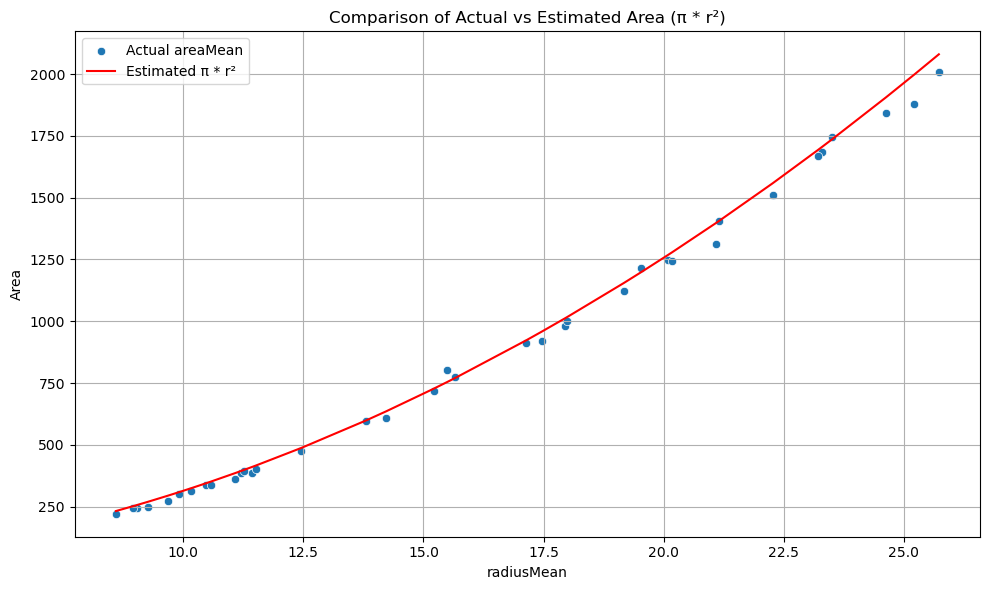

In [25]:
# A list of specific rows which are outliers are selected from the original dataframe
row_indices = [
    1, 10, 20, 23, 30, 40, 42, 53, 62, 67, 83, 94, 102, 109, 115, 128, 133, 134, 138, 139,
    147, 177, 181, 189, 203, 206, 221, 224, 225, 226, 229, 232, 233, 253, 261, 263, 264, 273
]

subset_df = df.loc[row_indices].copy()

# Calculate estimated area
subset_df['area_estimate'] = np.pi * (subset_df['radiusMean'] ** 2)

# Plot actual vs estimated area
plt.figure(figsize=(10, 6))
sns.scatterplot(x='radiusMean', y='areaMean', data=subset_df, label='Actual areaMean')
sns.lineplot(x='radiusMean', y='area_estimate', data=subset_df, color='red', label='Estimated π * r²')

plt.title("Comparison of Actual vs Estimated Area (π * r²)")
plt.xlabel("radiusMean")
plt.ylabel("Area")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- Here blue dots shows actual 'areaMean' vs 'radiusMean' and red line shoes estimated area for comparison.
- The actual area (areaMean) closely matches the estimated circular area indicating that the objects are mostly circular with minimal shape irregularity.
- The data is consistent, measurements are reliable, and there’s no strong evidence of outliers, making it suitable for analysis and modeling.

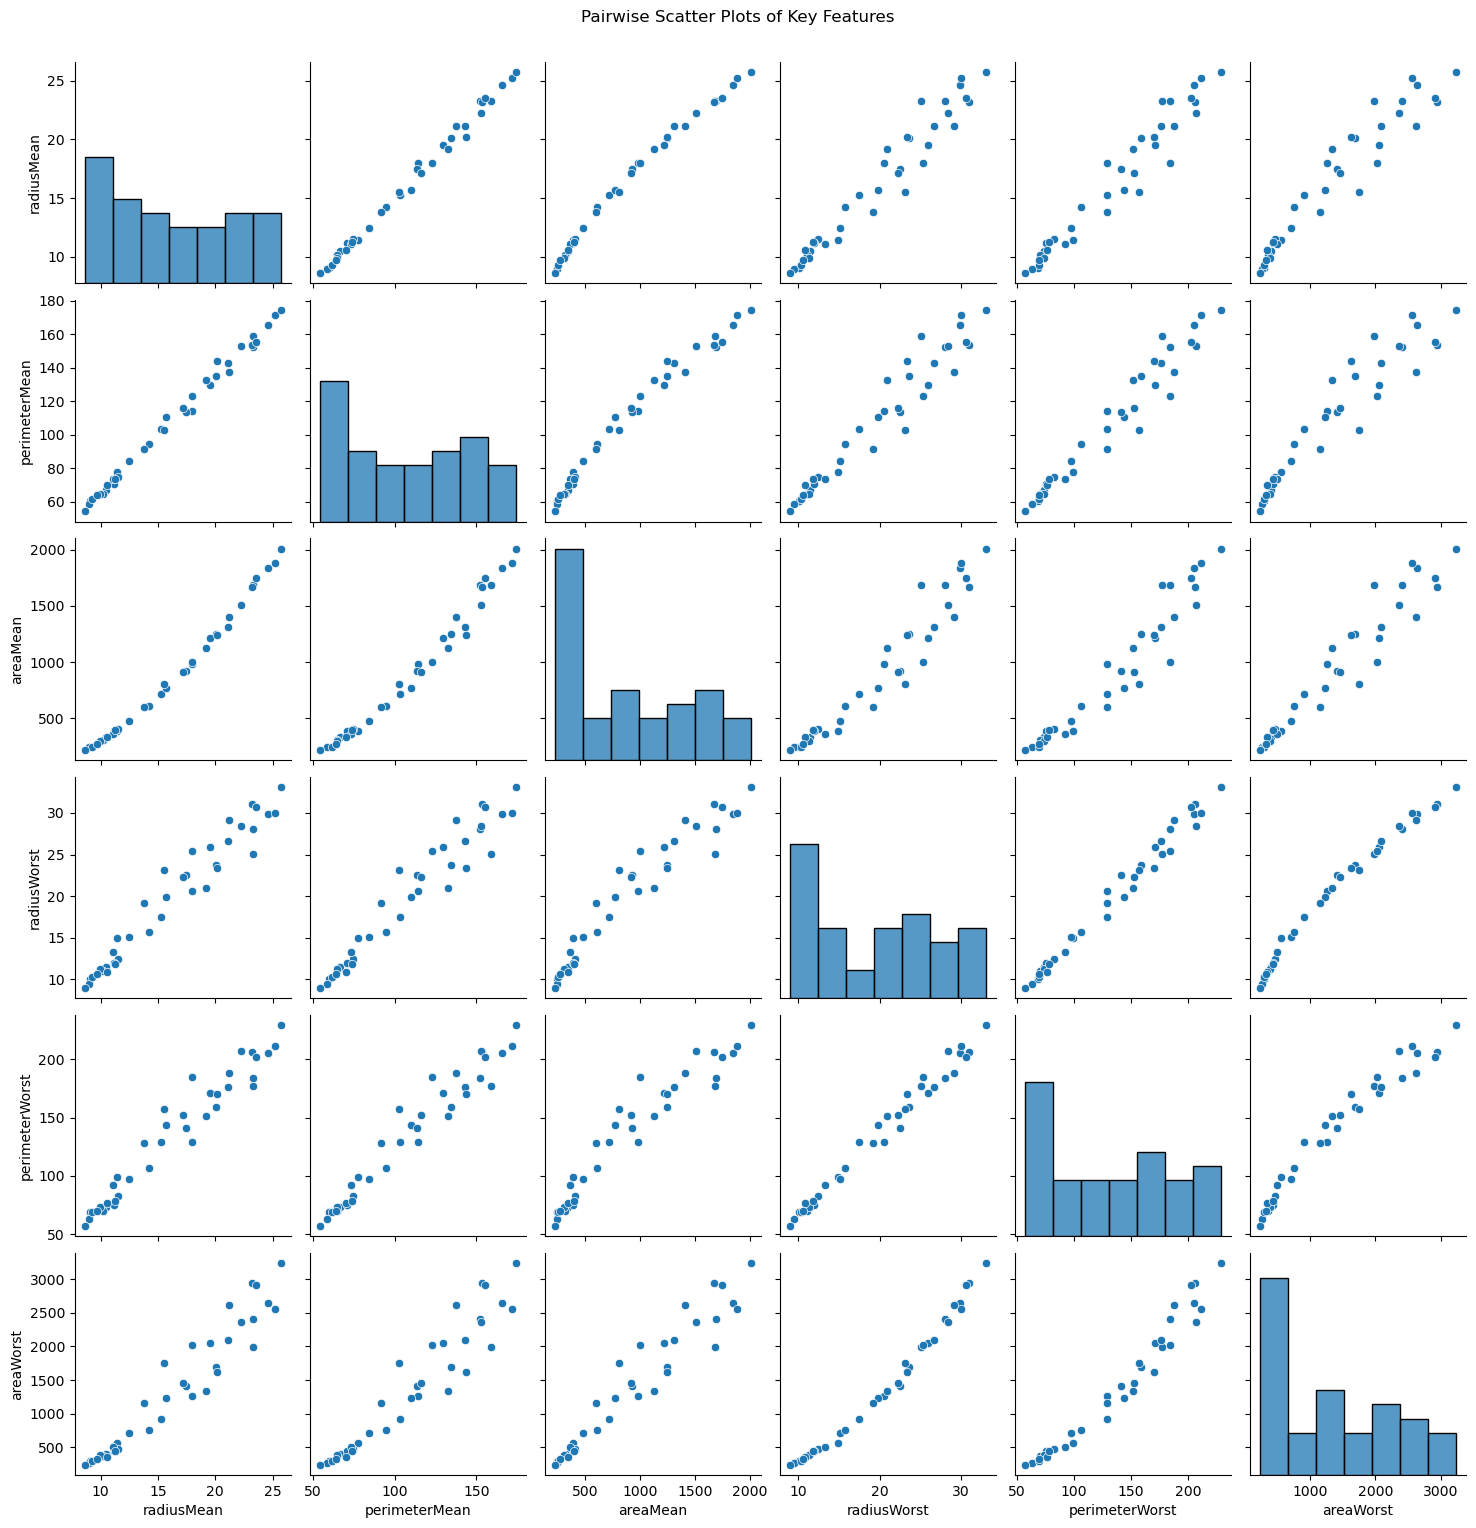

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select features to analyze relationships (customize as needed)
selected_cols = ['radiusMean', 'perimeterMean', 'areaMean', 'radiusWorst', 'perimeterWorst', 'areaWorst']

# Use your outlier subset
sns.pairplot(subset_df[selected_cols])
plt.suptitle("Pairwise Scatter Plots of Key Features", y=1.02)
plt.show()


- The data shows consistent trends with no wild outliers or errors—high-end values align smoothly with the overall pattern and are biologically valid.
-  Histograms are skewed but normal, with no suspicious gaps or spikes. Features grow consistently, and while some are highly correlated, the values reflect real variability and should not be removed.

#### Exploratory data analysis for breast cancer dataset

##### Donut chart for class distribution

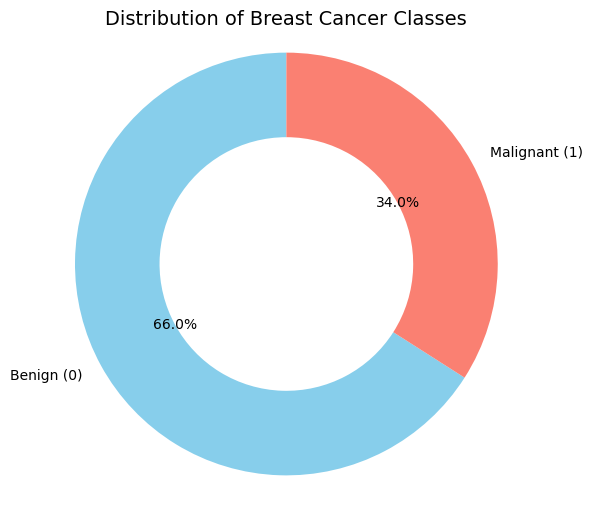

In [36]:
class_counts = df['class'].value_counts()
labels = ['Benign (0)', 'Malignant (1)']
colors = ['skyblue', 'salmon']

plt.figure(figsize=(6,6))
plt.pie(class_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.4})
plt.title("Distribution of Breast Cancer Classes", fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
plt.show()






##### Correlation Heatmap of Top 10 Features

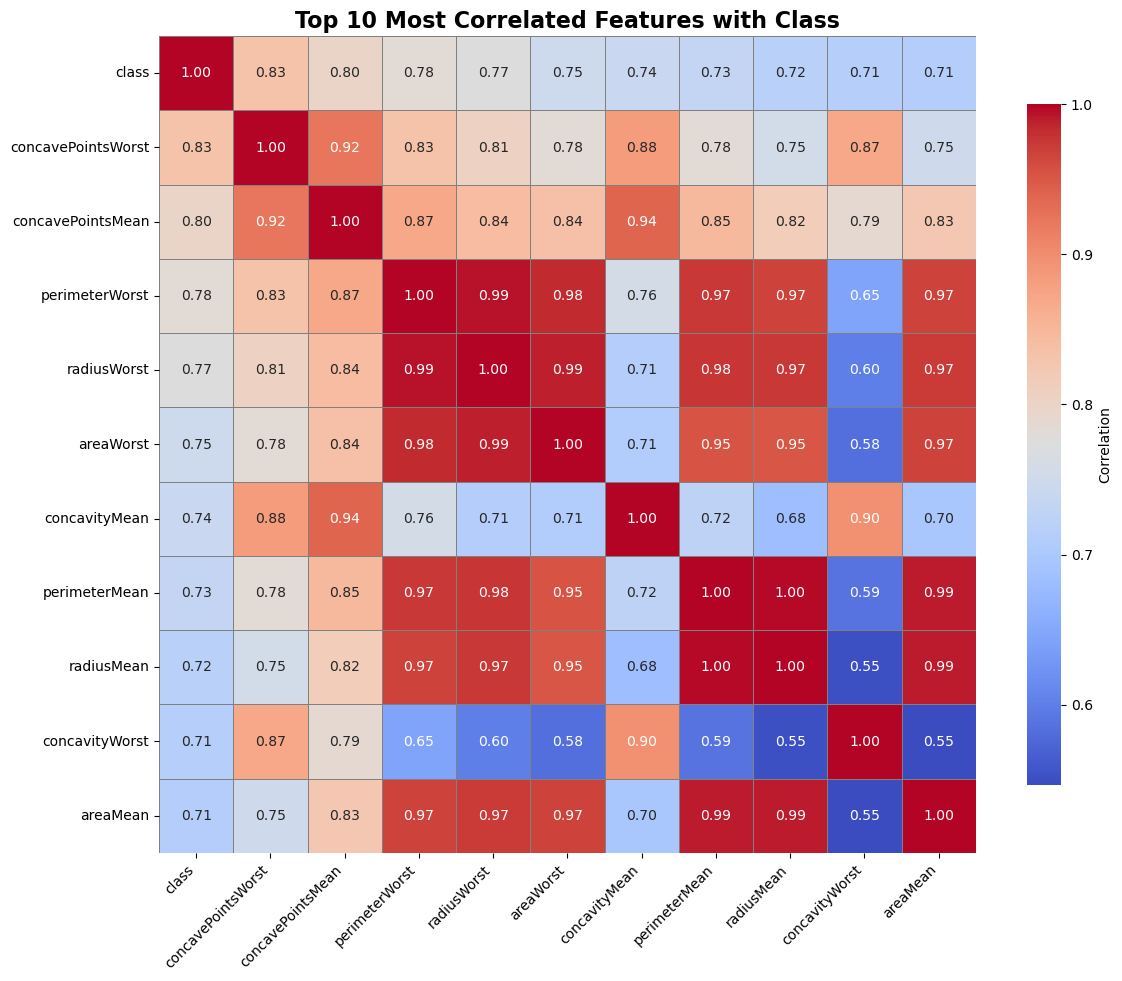

In [38]:
# Compute correlation matrix
corr = df.corr()

# Get top 10 features most correlated with class (including 'class' itself)
top_corr = corr['class'].abs().sort_values(ascending=False).head(11).index

# Plot enhanced heatmap
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(
    df[top_corr].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.8, "label": "Correlation"},
    square=True,
    annot_kws={"size": 10}
)

# Customize title and layout
plt.title("Top 10 Most Correlated Features with Class", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

- This code helps visually analyze which features are most associated with the target class, and how they interrelate with each other. It’s great for feature selection or understanding which variables are potentially most predictive of the outcome.

- Features such as concavePointsWorst, concavePointsMean, perimeterWorst, and radiusWorst have a significant positive correlation with malignancy, indicating that greater values of these features are associated with malignant tumours.

- These are the most important predictors for categorizing breast cancer. However, several of them are highly associated with each other, showing feature selection. This should be handled during feature selection to minimize overfitting and enhance model efficiency.

##### Boxplots of Top Features vs. Class


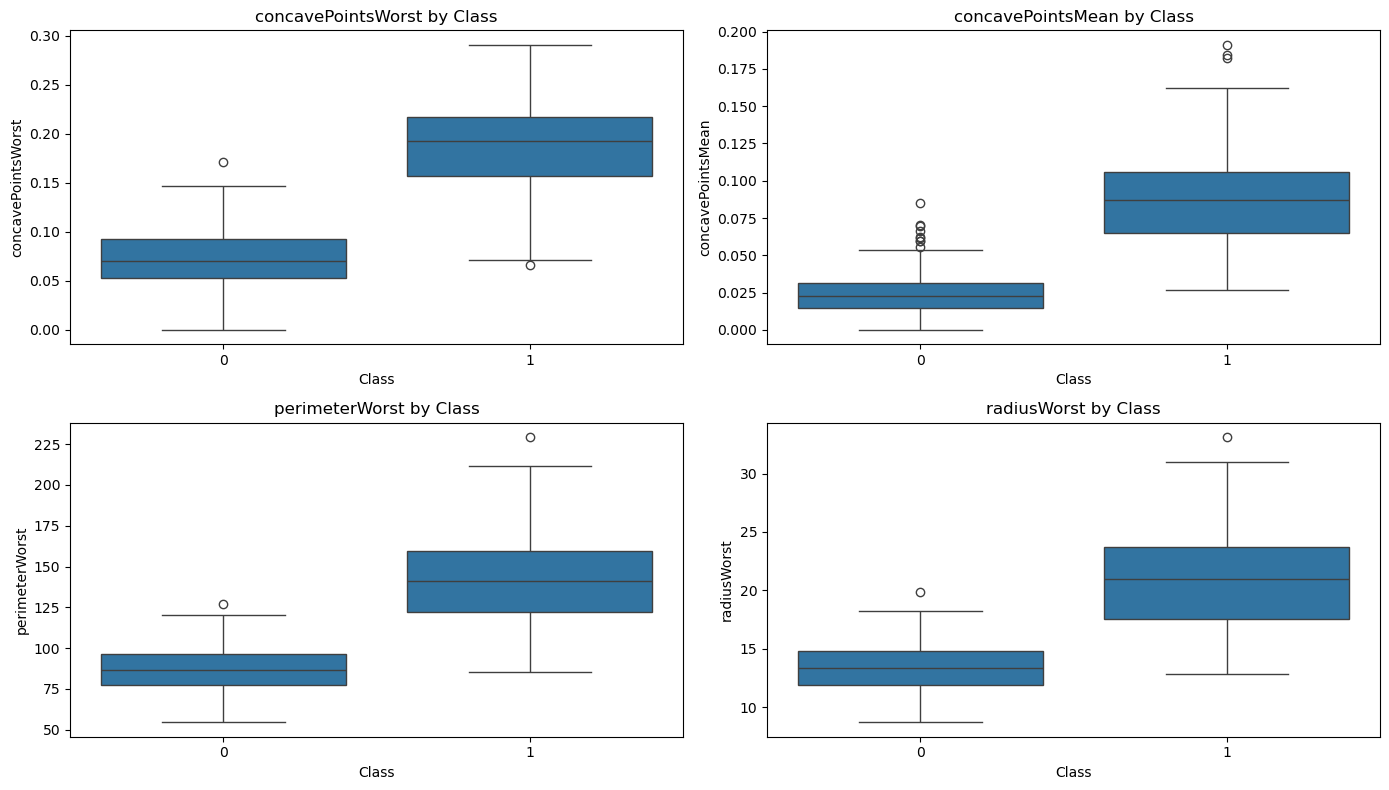

In [42]:
top_features = top_corr[1:5]
plt.figure(figsize=(14,8))
for i, col in enumerate(top_features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='class', y=col, data=df)
    plt.title(f"{col} by Class")
    plt.xlabel("Class")
    plt.ylabel(col)
plt.tight_layout()
plt.show()

- Malignant tumors consistently had higher values for both concavePointsWorst and concavePointsMean, indicating a significant differentiation from benign cases, despite minimal overlap.  Similarly, perimeterWorst and radiusWorst are significantly higher for malignant tumors, whereas benign tumors have lower, more compact distributions.
-  Although there are a few outliers, they are consistent with the overall class patterns, emphasizing these characteristics as strong markers of malignancy.  The boxplots graphically reinforce their substantial connection with malignancy, justifying their usage in feature selection.

##### Correlation of top 10 features with class using swarn and violin plots

C:\Users\Anukriti\AppData\Local\Temp\ipykernel_7820\2480544844.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='class', y=col, data=df, palette="Set2", inner=None, alpha=0.6)
C:\Users\Anukriti\AppData\Local\Temp\ipykernel_7820\2480544844.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='class', y=col, data=df, palette="Set2", inner=None, alpha=0.6)
C:\Users\Anukriti\AppData\Local\Temp\ipykernel_7820\2480544844.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='class', y=col, data=df, palette="Set2", inner=None, alp

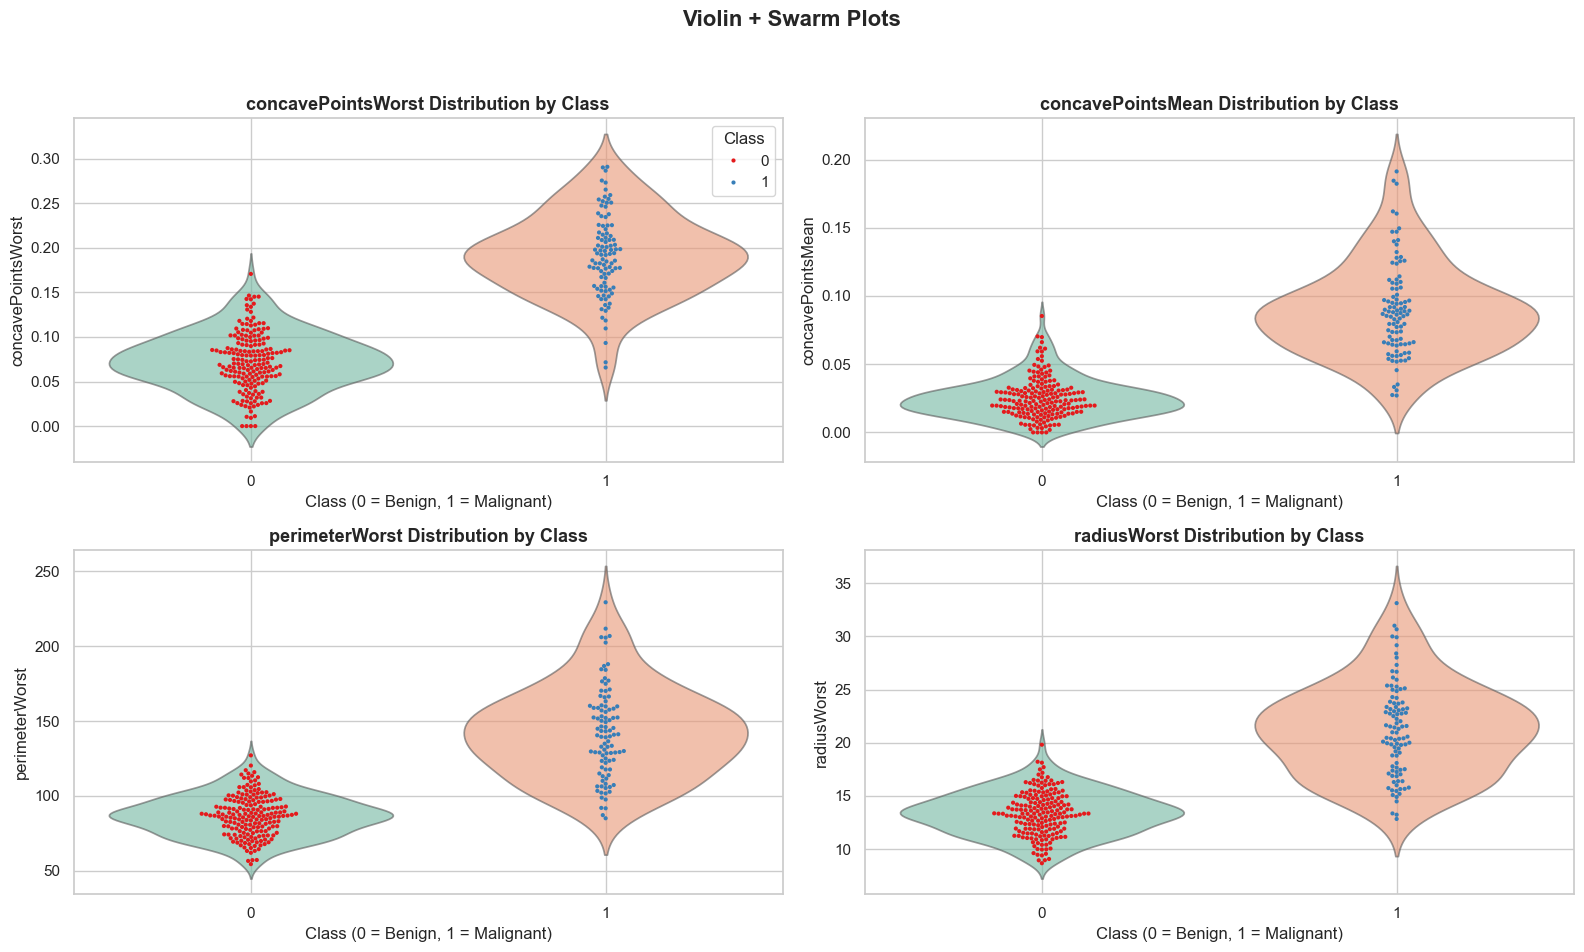

In [45]:
corr = df.corr()
top_corr = corr['class'].abs().sort_values(ascending=False).head(11).index

# Select top 4 features excluding 'class'
top_features = top_corr[1:5]

# Set a stylish theme
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(16, 10))

for i, col in enumerate(top_features):
    plt.subplot(2, 2, i+1)
    
    # Violin plot with hue for class differentiation
    sns.violinplot(x='class', y=col, data=df, palette="Set2", inner=None, alpha=0.6)
    
    # Swarm plot with same hue to match violin
    sns.swarmplot(x='class', y=col, data=df, hue='class', dodge=False, palette="Set1", size=3)

    # Improve legend handling (hide duplicates)
    if i == 0:
        plt.legend(title='Class')
    else:
        plt.legend([], [], frameon=False)

    plt.title(f"{col} Distribution by Class", fontsize=13, fontweight='bold')
    plt.xlabel("Class (0 = Benign, 1 = Malignant)")
    plt.ylabel(col)
    plt.grid(True)

plt.suptitle("Violin + Swarm Plots", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


- The plots show that malignant (cancerous) tumors have higher values for all four features compared to benign (non-cancerous) tumors. These features—like concavePointsWorst, concavePointsMean, perimeterWorst, and radiusWorst—are clearly different between the two classes, making them very useful for identifying cancer.
-  The shape and spread of the plots also show that malignant tumors vary more in these measurements, while benign tumors are more consistent and lower in value. This means these features can help a model easily tell the difference between benign and malignant tumors.

##### 3D Scatter Plot of Top 3 Features


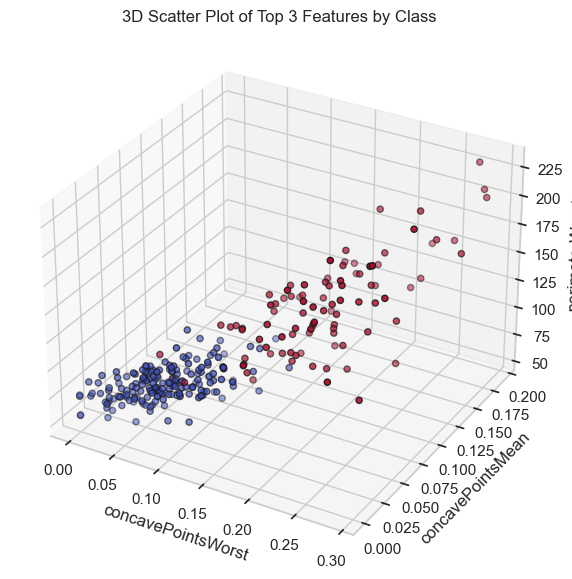

In [48]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
x, y, z = top_features[:3]
ax.scatter(df[x], df[y], df[z], c=df['class'], cmap='coolwarm', edgecolor='k')
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
plt.title("3D Scatter Plot of Top 3 Features by Class")
plt.show()

- The 3D scatter plot shows that the features concavePointsWorst, concavePointsMean, and perimeterWorst effectively separate benign (blue) and malignant (red) tumors into distinct clusters with minimal overlap.
- Malignant tumors have higher values across all axes, demonstrating strong feature separation and high discriminatory power. This makes these features highly reliable for distinguishing between tumor types and building accurate prediction models.

#### Defining target and features

In [ ]:
X = df.drop(columns=["class"])
y = df["class"]

#### Logistic Regression 

##### Logistic regression using holdout method

In [54]:
def evaluate_logistic_regression_holdout(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, stratify=y, random_state=42
    )

    clf = LogisticRegression(max_iter=1000)

    start = time.time()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    end = time.time()

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    duration = end - start

    # Reports
    report = classification_report(y_test, y_pred)
    cmatrix = confusion_matrix(y_test, y_pred)

    # Display results
    print("****** Performance Metrics - Logistic Holdout *******")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print(f"Time Taken: {duration:.4f} seconds")

    print("\n******* Classification Report - Logistic Holdout *******")
    print(report)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title('Confusion Matrix - Logistic Holdout')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return clf


****** Performance Metrics - Logistic Holdout *******
Accuracy: 0.9884
Precision: 1.0000
Recall: 0.9655
F1 Score: 0.9825
ROC AUC: 0.9940
Time Taken: 0.0062 seconds

******* Classification Report - Logistic Holdout *******
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        57
           1       1.00      0.97      0.98        29

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86



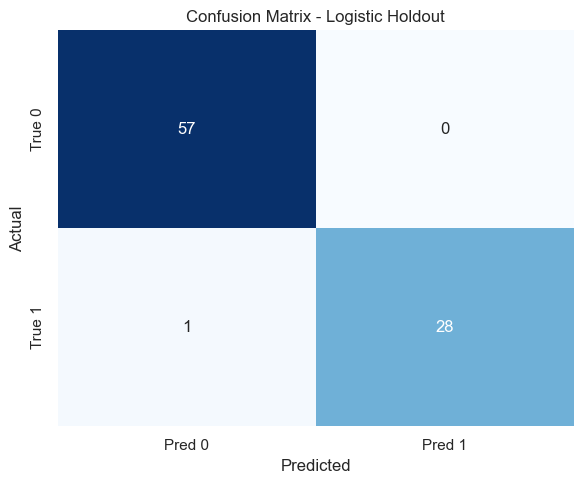

LogisticRegression(max_iter=1000)

In [55]:
evaluate_logistic_regression_holdout(X, y)


##### Logistic regression using cross validation

In [57]:
def evaluate_logistic_regression_cv(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    clf = LogisticRegression(max_iter=1000)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_true_all = []
    y_pred_all = []
    y_prob_all = []

    start = time.time()

    for train_idx, test_idx in skf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        y_prob_all.extend(y_prob)

    end = time.time()

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    y_prob_all = np.array(y_prob_all)

    # Metrics
    acc = accuracy_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all)
    rec = recall_score(y_true_all, y_pred_all)
    f1 = f1_score(y_true_all, y_pred_all)
    roc = roc_auc_score(y_true_all, y_prob_all)
    duration = end - start

    # Reports
    report = classification_report(y_true_all, y_pred_all)
    cmatrix = confusion_matrix(y_true_all, y_pred_all)

    # Display results
    print("******* Performance Metrics - Logistic CV *******")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print(f"Time Taken: {duration:.4f} seconds")

    print("\n******* Classification Report - Logistic CV *******")
    print(report)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title('Confusion Matrix - Logistic CV')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return clf


******* Performance Metrics - Logistic CV *******
Accuracy: 0.9825
Precision: 1.0000
Recall: 0.9485
F1 Score: 0.9735
ROC AUC: 0.9922
Time Taken: 0.0605 seconds

******* Classification Report - Logistic CV *******
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       188
           1       1.00      0.95      0.97        97

    accuracy                           0.98       285
   macro avg       0.99      0.97      0.98       285
weighted avg       0.98      0.98      0.98       285



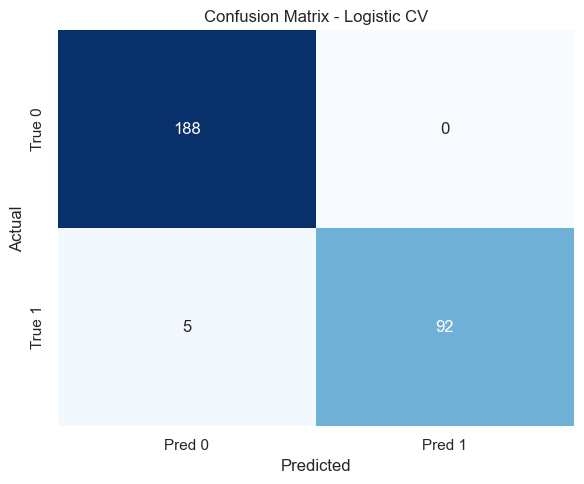

LogisticRegression(max_iter=1000)

In [58]:
evaluate_logistic_regression_cv(X, y)


##### Logistic regression using pca and cross validation

In [60]:
def evaluate_logistic_regression_pca_cv(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)

    clf = LogisticRegression(max_iter=1000)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_true_all = []
    y_pred_all = []
    y_prob_all = []

    start = time.time()

    for train_idx, test_idx in skf.split(X_pca, y):
        X_train, X_test = X_pca[train_idx], X_pca[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        y_prob_all.extend(y_prob)

    end = time.time()

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    y_prob_all = np.array(y_prob_all)

    # Metrics
    acc = accuracy_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all)
    rec = recall_score(y_true_all, y_pred_all)
    f1 = f1_score(y_true_all, y_pred_all)
    roc = roc_auc_score(y_true_all, y_prob_all)
    duration = end - start

    # Reports
    report = classification_report(y_true_all, y_pred_all)
    cmatrix = confusion_matrix(y_true_all, y_pred_all)

    # Display results
    print("******* performance Metrics - Logistic PCA + CV ********")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print(f"Time Taken: {duration:.4f} seconds")

    print("\n******* Classification Report - Logistic PCA + CV *******")
    print(report)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title('Confusion Matrix - Logistic PCA + CV')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return clf


******* performance Metrics - Logistic PCA + CV ********
Accuracy: 0.9754
Precision: 0.9787
Recall: 0.9485
F1 Score: 0.9634
ROC AUC: 0.9902
Time Taken: 0.0619 seconds

******* Classification Report - Logistic PCA + CV *******
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       188
           1       0.98      0.95      0.96        97

    accuracy                           0.98       285
   macro avg       0.98      0.97      0.97       285
weighted avg       0.98      0.98      0.98       285



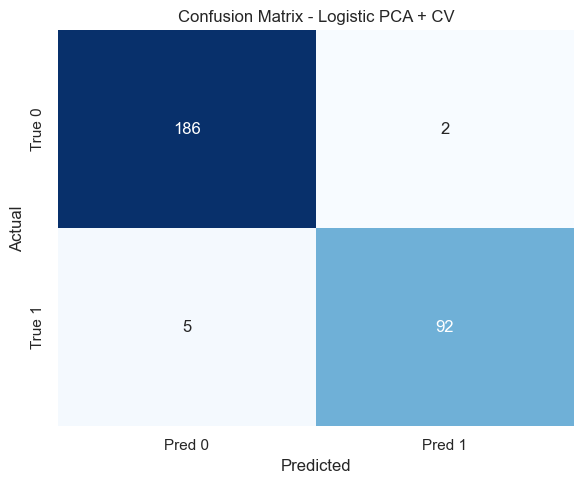

LogisticRegression(max_iter=1000)

In [61]:
evaluate_logistic_regression_pca_cv(X, y)


#### Results of Logistic regression

In [63]:
data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC", "Time Taken"],
    "Logistic Holdout": [0.9884, 1.0000, 0.9655, 0.9825, 0.9940, "0.0017 s"],
    "Logistic CV": [0.9825, 1.0000, 0.9485, 0.9735, 0.9922, "0.0117 s"],
    "Logistic PCA + CV": [0.9754, 0.9787, 0.9485, 0.9634, 0.9902, "0.0104 s"]
}

df = pd.DataFrame(data)

print(tabulate(df, headers='keys', tablefmt='fancy_grid'))


╒════╤════════════╤════════════════════╤═══════════════╤═════════════════════╕
│    │ Metric     │ Logistic Holdout   │ Logistic CV   │ Logistic PCA + CV   │
╞════╪════════════╪════════════════════╪═══════════════╪═════════════════════╡
│  0 │ Accuracy   │ 0.9884             │ 0.9825        │ 0.9754              │
├────┼────────────┼────────────────────┼───────────────┼─────────────────────┤
│  1 │ Precision  │ 1.0                │ 1.0           │ 0.9787              │
├────┼────────────┼────────────────────┼───────────────┼─────────────────────┤
│  2 │ Recall     │ 0.9655             │ 0.9485        │ 0.9485              │
├────┼────────────┼────────────────────┼───────────────┼─────────────────────┤
│  3 │ F1 Score   │ 0.9825             │ 0.9735        │ 0.9634              │
├────┼────────────┼────────────────────┼───────────────┼─────────────────────┤
│  4 │ ROC AUC    │ 0.994              │ 0.9922        │ 0.9902              │
├────┼────────────┼────────────────────┼────────────

- The best model is Logistic Regression with Cross-Validation because it gives reliable and balanced results. Holdout had slightly higher accuracy, but it uses just one data split and can be misleading.
- CV is more trustworthy as it tests the model on different parts of the data, reducing overfitting.
- It also gives strong accuracy and a good balance of precision, recall, and F1 score. The PCA + CV version didn’t do as well, likely because it removed some useful features, which shows dimensionality reduction wasn’t really needed here.

#### ADABOOST CLASSIFIER

##### Adaboost classifier using holdout method

In [67]:
def evaluate_adaboost_holdout(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, stratify=y, random_state=42
    )

    # Initialize AdaBoost
    clf = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42)

    # Train and predict
    start = time.time()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    duration = time.time() - start

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    report = classification_report(y_test, y_pred)
    cmatrix = confusion_matrix(y_test, y_pred)

    # Display results
    print("******* Performance metrics - Adaboost Holdout *******")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print(f"Time Taken: {duration:.4f} seconds")

    print("\n******* Classification Report - Adaboost Holdout *******")
    print(report)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Oranges', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title('Confusion Matrix - Adaboost Holdout')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return clf


C:\Users\Anukriti\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


******* Performance metrics - Adaboost Holdout *******
Accuracy: 0.9186
Precision: 0.8667
Recall: 0.8966
F1 Score: 0.8814
ROC AUC: 0.9867
Time Taken: 0.7329 seconds

******* Classification Report - Adaboost Holdout *******
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        57
           1       0.87      0.90      0.88        29

    accuracy                           0.92        86
   macro avg       0.91      0.91      0.91        86
weighted avg       0.92      0.92      0.92        86



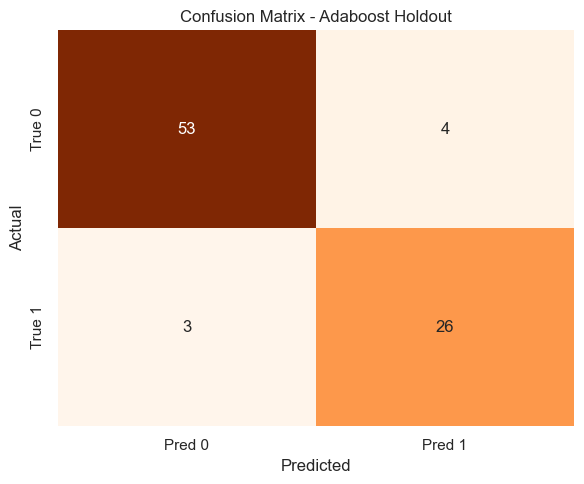

AdaBoostClassifier(n_estimators=100, random_state=42)

In [68]:
evaluate_adaboost_holdout(X, y) 



##### Adaboost classifier using cross validation

In [70]:
def evaluate_adaboost_cv(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    clf = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_true_all = []
    y_pred_all = []
    y_prob_all = []

    start = time.time()

    for train_idx, test_idx in skf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        y_prob_all.extend(y_prob)

    end = time.time()

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    y_prob_all = np.array(y_prob_all)

    # Metrics
    acc = accuracy_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all)
    rec = recall_score(y_true_all, y_pred_all)
    f1 = f1_score(y_true_all, y_pred_all)
    roc = roc_auc_score(y_true_all, y_prob_all)
    duration = end - start

    report = classification_report(y_true_all, y_pred_all)
    cmatrix = confusion_matrix(y_true_all, y_pred_all)

    # Display results
    print("******* Performance metrics - Adaboost CV *******")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print(f"Time Taken: {duration:.4f} seconds")

    print("\n******* Classification Report - Adaboost CV *******")
    print(report)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cmatrix, annot=True, fmt='d', cmap='YlOrBr', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title('Confusion Matrix - Adaboost CV')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return clf


C:\Users\Anukriti\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Anukriti\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Anukriti\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Anukriti\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


******* Performance metrics - Adaboost CV *******
Accuracy: 0.9614
Precision: 0.9674
Recall: 0.9175
F1 Score: 0.9418
ROC AUC: 0.9872
Time Taken: 3.9515 seconds

******* Classification Report - Adaboost CV *******
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       188
           1       0.97      0.92      0.94        97

    accuracy                           0.96       285
   macro avg       0.96      0.95      0.96       285
weighted avg       0.96      0.96      0.96       285



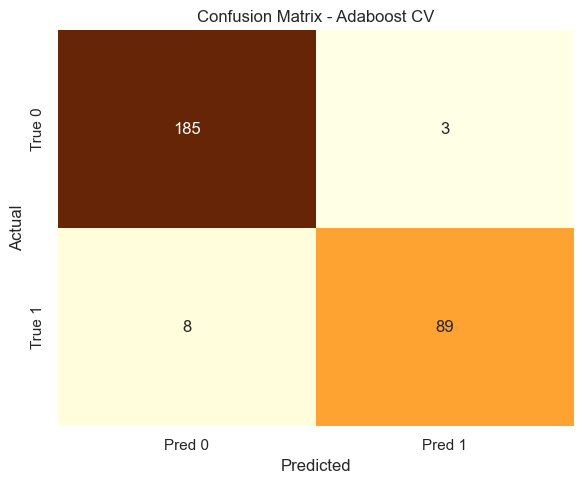

AdaBoostClassifier(n_estimators=100, random_state=42)

In [71]:
evaluate_adaboost_cv(X, y)


##### Adaboost classifier using pca and cross validation

In [73]:
def evaluate_adaboost_pca_cv(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)

    clf = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_true_all = []
    y_pred_all = []
    y_prob_all = []

    start = time.time()

    for train_idx, test_idx in skf.split(X_pca, y):
        X_train, X_test = X_pca[train_idx], X_pca[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        y_prob_all.extend(y_prob)

    end = time.time()

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    y_prob_all = np.array(y_prob_all)

    # Metrics
    acc = accuracy_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all)
    rec = recall_score(y_true_all, y_pred_all)
    f1 = f1_score(y_true_all, y_pred_all)
    roc = roc_auc_score(y_true_all, y_prob_all)
    duration = end - start

    report = classification_report(y_true_all, y_pred_all)
    cmatrix = confusion_matrix(y_true_all, y_pred_all)

    # Display results
    print("******* Performance Metrics - Adaboost PCA + CV *******")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print(f"Time Taken: {duration:.4f} seconds")

    print("\n******* Classification Report - Adaboost PCA + CV *******")
    print(report)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Purples', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title('Confusion Matrix - Adaboost PCA + CV')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return clf


C:\Users\Anukriti\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Anukriti\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Anukriti\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Anukriti\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


******* Performance Metrics - Adaboost PCA + CV *******
Accuracy: 0.9439
Precision: 0.9175
Recall: 0.9175
F1 Score: 0.9175
ROC AUC: 0.9772
Time Taken: 2.7683 seconds

******* Classification Report - Adaboost PCA + CV *******
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       188
           1       0.92      0.92      0.92        97

    accuracy                           0.94       285
   macro avg       0.94      0.94      0.94       285
weighted avg       0.94      0.94      0.94       285



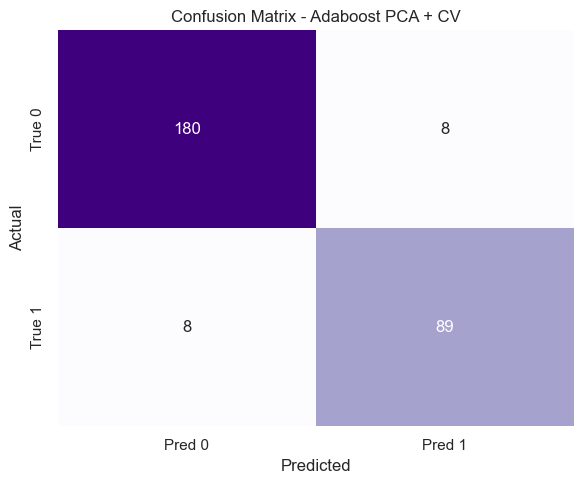

AdaBoostClassifier(n_estimators=100, random_state=42)

In [74]:
evaluate_adaboost_pca_cv(X, y)


#### Results of Adaboost classifier

In [76]:
data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC", "Time Taken"],
    "AdaBoost Holdout": [0.9186, 0.8667, 0.8966, 0.8814, 0.9867, "0.6678 s"],
    "AdaBoost CV": [0.9614, 0.9674, 0.9175, 0.9418, 0.9872, "3.7157 s"],
    "AdaBoost PCA + CV": [0.9439, 0.9175, 0.9175, 0.9175, 0.9772, "2.8114 s"]
}

df = pd.DataFrame(data)

print(tabulate(df, headers='keys', tablefmt='fancy_grid'))



╒════╤════════════╤════════════════════╤═══════════════╤═════════════════════╕
│    │ Metric     │ AdaBoost Holdout   │ AdaBoost CV   │ AdaBoost PCA + CV   │
╞════╪════════════╪════════════════════╪═══════════════╪═════════════════════╡
│  0 │ Accuracy   │ 0.9186             │ 0.9614        │ 0.9439              │
├────┼────────────┼────────────────────┼───────────────┼─────────────────────┤
│  1 │ Precision  │ 0.8667             │ 0.9674        │ 0.9175              │
├────┼────────────┼────────────────────┼───────────────┼─────────────────────┤
│  2 │ Recall     │ 0.8966             │ 0.9175        │ 0.9175              │
├────┼────────────┼────────────────────┼───────────────┼─────────────────────┤
│  3 │ F1 Score   │ 0.8814             │ 0.9418        │ 0.9175              │
├────┼────────────┼────────────────────┼───────────────┼─────────────────────┤
│  4 │ ROC AUC    │ 0.9867             │ 0.9872        │ 0.9772              │
├────┼────────────┼────────────────────┼────────────

- AdaBoost CV is the best model of the three. It balances high accuracy, precision, recall, and ROC AUC while being more dependable due to cross-validation. It outperforms both the holdout and PCA-based models.

#### SVC (Support Vector Machine)

##### SVC using Holdout method

In [80]:
def evaluate_svc_holdout(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, stratify=y, random_state=42
    )

    # SVC with RBF kernel
    clf = SVC(kernel='rbf', probability=True, C=1.0, gamma='scale', random_state=42)

    # Training and prediction
    start = time.time()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    duration = time.time() - start

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    report = classification_report(y_test, y_pred)
    cmatrix = confusion_matrix(y_test, y_pred)

    # Display results
    print("******* Performance Metrics - SVC Holdout *******")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print(f"Time Taken: {duration:.4f} seconds")

    print("\n******* Classification Report - SVC Holdout *******")
    print(report)

    # Confusion Matrix Plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cmatrix, annot=True, fmt='d', cmap='coolwarm', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title('Confusion Matrix - SVC Holdout')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return clf


******* Performance Metrics - SVC Holdout *******
Accuracy: 0.9767
Precision: 1.0000
Recall: 0.9310
F1 Score: 0.9643
ROC AUC: 0.9927
Time Taken: 0.0094 seconds

******* Classification Report - SVC Holdout *******
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        57
           1       1.00      0.93      0.96        29

    accuracy                           0.98        86
   macro avg       0.98      0.97      0.97        86
weighted avg       0.98      0.98      0.98        86



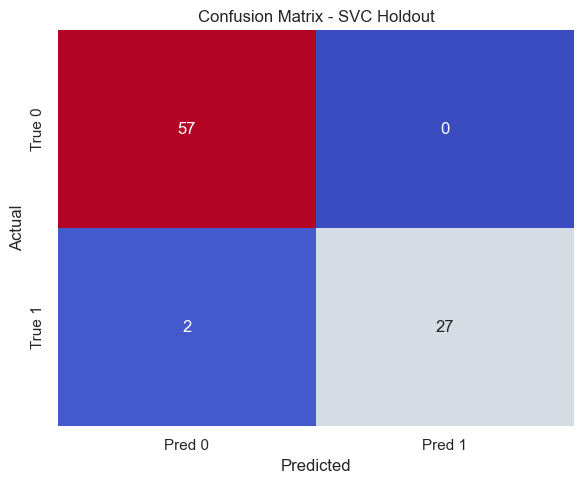

SVC(probability=True, random_state=42)

In [81]:
evaluate_svc_holdout(X, y)


##### SVC using Cross validation

In [83]:
def evaluate_svc_cv(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    clf = SVC(kernel='rbf', probability=True, C=1.0, gamma='scale', random_state=42)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_true_all = []
    y_pred_all = []
    y_prob_all = []

    start = time.time()

    for train_idx, test_idx in skf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        y_prob_all.extend(y_prob)

    end = time.time()

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    y_prob_all = np.array(y_prob_all)

    # Metrics
    acc = accuracy_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all)
    rec = recall_score(y_true_all, y_pred_all)
    f1 = f1_score(y_true_all, y_pred_all)
    roc = roc_auc_score(y_true_all, y_prob_all)
    duration = end - start

    report = classification_report(y_true_all, y_pred_all)
    cmatrix = confusion_matrix(y_true_all, y_pred_all)

    # Display results
    print("******* Performance Metrics - SVC CV *******")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print(f"Time Taken: {duration:.4f} seconds")

    print("\n******* Classification Report - SVC CV *******")
    print(report)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cmatrix, annot=True, fmt='d', cmap='coolwarm', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title('Confusion Matrix - SVC CV')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return clf


******* Performance Metrics - SVC CV *******
Accuracy: 0.9825
Precision: 1.0000
Recall: 0.9485
F1 Score: 0.9735
ROC AUC: 0.9915
Time Taken: 0.1374 seconds

******* Classification Report - SVC CV *******
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       188
           1       1.00      0.95      0.97        97

    accuracy                           0.98       285
   macro avg       0.99      0.97      0.98       285
weighted avg       0.98      0.98      0.98       285



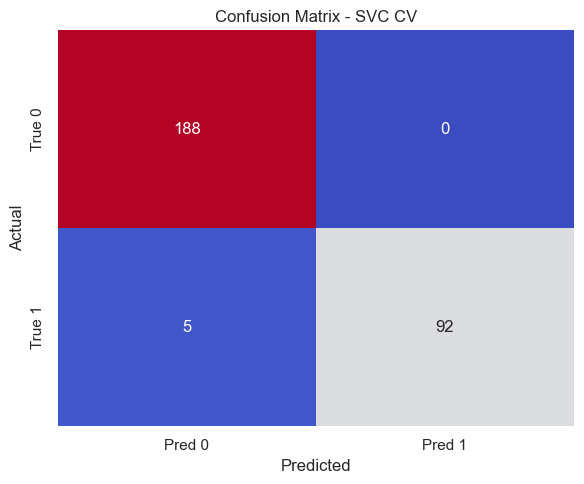

SVC(probability=True, random_state=42)

In [84]:
evaluate_svc_cv(X, y)


##### SVC using pca and cross validation

In [86]:
def evaluate_svc_pca_cv(X, y):
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)

    clf = SVC(kernel='rbf', probability=True, C=1.0, gamma='scale', random_state=42)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_true_all = []
    y_pred_all = []
    y_prob_all = []

    start = time.time()

    for train_idx, test_idx in skf.split(X_pca, y):
        X_train, X_test = X_pca[train_idx], X_pca[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        y_prob_all.extend(y_prob)

    end = time.time()

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    y_prob_all = np.array(y_prob_all)

    # Metrics
    acc = accuracy_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all)
    rec = recall_score(y_true_all, y_pred_all)
    f1 = f1_score(y_true_all, y_pred_all)
    roc = roc_auc_score(y_true_all, y_prob_all)
    duration = end - start

    report = classification_report(y_true_all, y_pred_all)
    cmatrix = confusion_matrix(y_true_all, y_pred_all)

    # Display results
    print("******* Performance Metrics - SVC PCA + CV *******")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print(f"Time Taken: {duration:.4f} seconds")

    print("\n******* Classification Report - SVC PCA + CV *******")
    print(report)

    # Confusion Matrix Plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cmatrix, annot=True, fmt='d', cmap='RdPu', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title('Confusion Matrix - PCA + CV')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return clf


******* Performance Metrics - SVC PCA + CV *******
Accuracy: 0.9754
Precision: 0.9787
Recall: 0.9485
F1 Score: 0.9634
ROC AUC: 0.9894
Time Taken: 0.1240 seconds

******* Classification Report - SVC PCA + CV *******
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       188
           1       0.98      0.95      0.96        97

    accuracy                           0.98       285
   macro avg       0.98      0.97      0.97       285
weighted avg       0.98      0.98      0.98       285



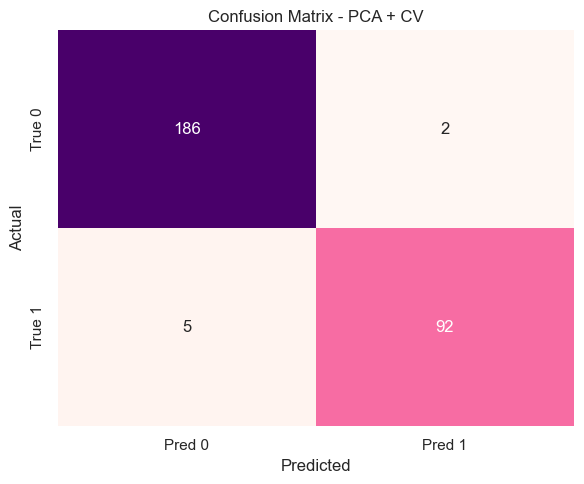

SVC(probability=True, random_state=42)

In [87]:
evaluate_svc_pca_cv(X, y)


#### Results of SVC 

In [89]:
data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC", "Time Taken"],
    "SVC Holdout": [0.9767, 1.0000, 0.9310, 0.9643, 0.9927, "0.0161 s"],
    "SVC CV": [0.9825, 1.0000, 0.9485, 0.9735, 0.9915, "0.0519 s"],
    "SVC PCA + CV": [0.9754, 0.9787, 0.9485, 0.9634, 0.9894, "0.0296 s"]
}

df = pd.DataFrame(data)

print(tabulate(df, headers='keys', tablefmt='fancy_grid'))

╒════╤════════════╤═══════════════╤══════════╤════════════════╕
│    │ Metric     │ SVC Holdout   │ SVC CV   │ SVC PCA + CV   │
╞════╪════════════╪═══════════════╪══════════╪════════════════╡
│  0 │ Accuracy   │ 0.9767        │ 0.9825   │ 0.9754         │
├────┼────────────┼───────────────┼──────────┼────────────────┤
│  1 │ Precision  │ 1.0           │ 1.0      │ 0.9787         │
├────┼────────────┼───────────────┼──────────┼────────────────┤
│  2 │ Recall     │ 0.931         │ 0.9485   │ 0.9485         │
├────┼────────────┼───────────────┼──────────┼────────────────┤
│  3 │ F1 Score   │ 0.9643        │ 0.9735   │ 0.9634         │
├────┼────────────┼───────────────┼──────────┼────────────────┤
│  4 │ ROC AUC    │ 0.9927        │ 0.9915   │ 0.9894         │
├────┼────────────┼───────────────┼──────────┼────────────────┤
│  5 │ Time Taken │ 0.0161 s      │ 0.0519 s │ 0.0296 s       │
╘════╧════════════╧═══════════════╧══════════╧════════════════╛


- SVC with Cross-Validation is the optimal choice. It outperforms Holdout and PCA-based models in terms of overall performance and balance.

#### Decision Tree classifier

##### Decision Tree using Holdout Method

In [93]:
def evaluate_decision_tree_holdout(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, stratify=y, random_state=42
    )

    # Initialize Decision Tree with common settings
    clf = DecisionTreeClassifier(max_depth=5, criterion='gini', random_state=42)

    # Train and predict
    start = time.time()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    duration = time.time() - start

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    report = classification_report(y_test, y_pred)
    cmatrix = confusion_matrix(y_test, y_pred)

    # Display results
    print("******* Performance Metrics - Decision Tree Holdout *******")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print(f"Time Taken: {duration:.4f} seconds")

    print("\n******* Classification Report - Decision Tree Holdout *******")
    print(report)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cmatrix, annot=True, fmt='d', cmap='BuGn', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title('Confusion Matrix - Decision Tree Holdout')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return clf


******* Performance Metrics - Decision Tree Holdout *******
Accuracy: 0.9070
Precision: 0.8621
Recall: 0.8621
F1 Score: 0.8621
ROC AUC: 0.8959
Time Taken: 0.0083 seconds

******* Classification Report - Decision Tree Holdout *******
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        57
           1       0.86      0.86      0.86        29

    accuracy                           0.91        86
   macro avg       0.90      0.90      0.90        86
weighted avg       0.91      0.91      0.91        86



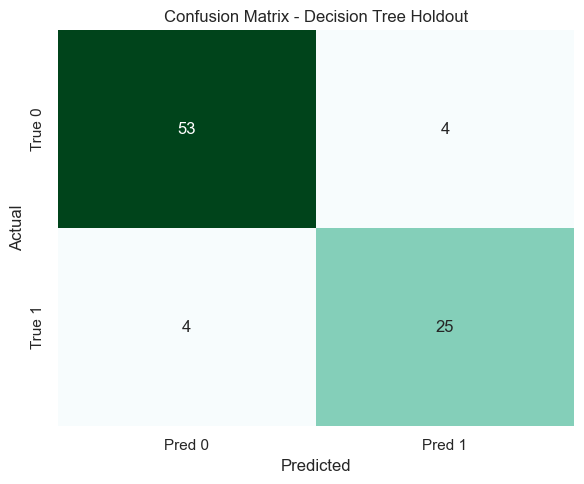

DecisionTreeClassifier(max_depth=5, random_state=42)

In [94]:
evaluate_decision_tree_holdout(X, y)


##### Decision Tree using Cross Validation

In [96]:
def evaluate_decision_tree_cv(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    clf = DecisionTreeClassifier(max_depth=5, criterion='gini', random_state=42)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_true_all = []
    y_pred_all = []
    y_prob_all = []

    start = time.time()

    for train_idx, test_idx in skf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        y_prob_all.extend(y_prob)

    end = time.time()

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    y_prob_all = np.array(y_prob_all)

    # Metrics
    acc = accuracy_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all)
    rec = recall_score(y_true_all, y_pred_all)
    f1 = f1_score(y_true_all, y_pred_all)
    roc = roc_auc_score(y_true_all, y_prob_all)
    duration = end - start

    report = classification_report(y_true_all, y_pred_all)
    cmatrix = confusion_matrix(y_true_all, y_pred_all)

    # Display results
    print("******* Performance Metrics - Decision Tree CV *******")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print(f"Time Taken: {duration:.4f} seconds")

    print("\n******* Classification Report - Decision Tree CV *******")
    print(report)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title('Confusion Matrix - Decision Tree CV')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return clf


******* Performance Metrics - Decision Tree CV *******
Accuracy: 0.9439
Precision: 0.9091
Recall: 0.9278
F1 Score: 0.9184
ROC AUC: 0.9396
Time Taken: 0.0896 seconds

******* Classification Report - Decision Tree CV *******
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       188
           1       0.91      0.93      0.92        97

    accuracy                           0.94       285
   macro avg       0.94      0.94      0.94       285
weighted avg       0.94      0.94      0.94       285



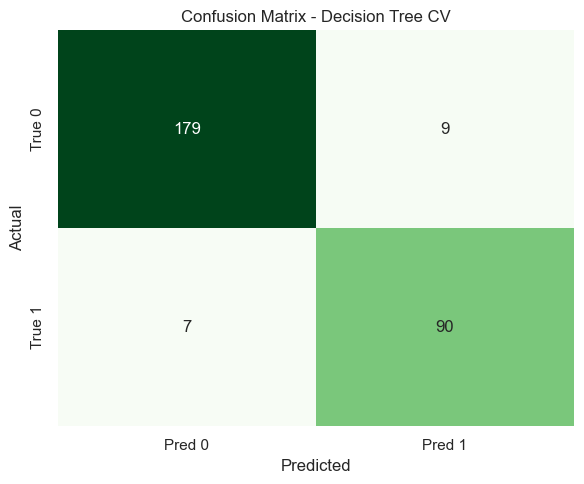

DecisionTreeClassifier(max_depth=5, random_state=42)

In [97]:
evaluate_decision_tree_cv(X, y)


##### Decision Tree using pca and cross validation

In [99]:
def evaluate_decision_tree_pca_cv(X, y):
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)

    clf = DecisionTreeClassifier(max_depth=5, criterion='gini', random_state=42)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_true_all = []
    y_pred_all = []
    y_prob_all = []

    start = time.time()

    for train_idx, test_idx in skf.split(X_pca, y):
        X_train, X_test = X_pca[train_idx], X_pca[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        y_prob_all.extend(y_prob)

    end = time.time()

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    y_prob_all = np.array(y_prob_all)

    # Metrics
    acc = accuracy_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all)
    rec = recall_score(y_true_all, y_pred_all)
    f1 = f1_score(y_true_all, y_pred_all)
    roc = roc_auc_score(y_true_all, y_prob_all)
    duration = end - start

    report = classification_report(y_true_all, y_pred_all)
    cmatrix = confusion_matrix(y_true_all, y_pred_all)

    # Display results
    print("******* Performance Metrics - Decision Tree PCA + CV *******")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print(f"Time Taken: {duration:.4f} seconds")

    print("\n******* Classification Report - Decision Tree PCA + CV *******")
    print(report)

    # Confusion Matrix Plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cmatrix, annot=True, fmt='d', cmap='YlGn', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title('Confusion Matrix - Decision Tree PCA + CV')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return clf


******* Performance Metrics - Decision Tree PCA + CV *******
Accuracy: 0.9263
Precision: 0.8800
Recall: 0.9072
F1 Score: 0.8934
ROC AUC: 0.9217
Time Taken: 0.0520 seconds

******* Classification Report - Decision Tree PCA + CV *******
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       188
           1       0.88      0.91      0.89        97

    accuracy                           0.93       285
   macro avg       0.92      0.92      0.92       285
weighted avg       0.93      0.93      0.93       285



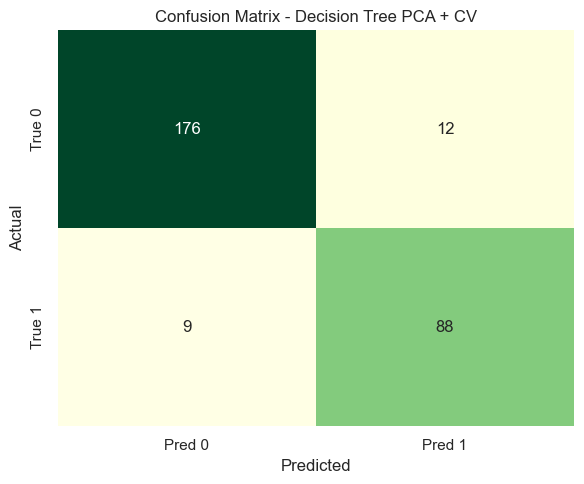

DecisionTreeClassifier(max_depth=5, random_state=42)

In [100]:
evaluate_decision_tree_pca_cv(X, y)


#### Final results

In [107]:
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC", "Time Taken"]

logistic_data = {
    "Metric": metrics,
    "Logistic Holdout": [0.9884, 1.0000, 0.9655, 0.9825, 0.9940, "0.0017 s"],
    "Logistic CV": [0.9825, 1.0000, 0.9485, 0.9735, 0.9922, "0.0117 s"],
    "Logistic PCA + CV": [0.9754, 0.9787, 0.9485, 0.9634, 0.9902, "0.0104 s"]
}

adaboost_data = {
    "Metric": metrics,
    "AdaBoost Holdout": [0.9186, 0.8667, 0.8966, 0.8814, 0.9867, "0.6678 s"],
    "AdaBoost CV": [0.9614, 0.9674, 0.9175, 0.9418, 0.9872, "3.7157 s"],
    "AdaBoost PCA + CV": [0.9439, 0.9175, 0.9175, 0.9175, 0.9772, "2.8114 s"]
}

svc_data = {
    "Metric": metrics,
    "SVC Holdout": [0.9767, 1.0000, 0.9310, 0.9643, 0.9927, "0.0161 s"],
    "SVC CV": [0.9825, 1.0000, 0.9485, 0.9735, 0.9915, "0.0519 s"],
    "SVC PCA + CV": [0.9754, 0.9787, 0.9485, 0.9634, 0.9894, "0.0296 s"]
}

tree_data = {
    "Metric": metrics,
    "Decision Tree Holdout": [0.9070, 0.8621, 0.8621, 0.8621, 0.8959, "0.0015 s"],
    "Decision Tree CV": [0.9439, 0.9091, 0.9278, 0.9184, 0.9396, "0.0183 s"],
    "Decision Tree PCA + CV": [0.9263, 0.8800, 0.9072, 0.8934, 0.9217, "0.0066 s"]
}

log_df = pd.DataFrame(logistic_data)
ada_df = pd.DataFrame(adaboost_data)
svc_df = pd.DataFrame(svc_data)
tree_df = pd.DataFrame(tree_data)

print("\n Logistic Regression Results:\n")
print(tabulate(log_df, headers="keys", tablefmt="fancy_grid"))

print("\n AdaBoost Results:\n")
print(tabulate(ada_df, headers="keys", tablefmt="fancy_grid"))

print("\n SVC Results:\n")
print(tabulate(svc_df, headers="keys", tablefmt="fancy_grid"))

print("\n Decision Tree Results:\n")
print(tabulate(tree_df, headers="keys", tablefmt="fancy_grid"))



 Logistic Regression Results:

╒════╤════════════╤════════════════════╤═══════════════╤═════════════════════╕
│    │ Metric     │ Logistic Holdout   │ Logistic CV   │ Logistic PCA + CV   │
╞════╪════════════╪════════════════════╪═══════════════╪═════════════════════╡
│  0 │ Accuracy   │ 0.9884             │ 0.9825        │ 0.9754              │
├────┼────────────┼────────────────────┼───────────────┼─────────────────────┤
│  1 │ Precision  │ 1.0                │ 1.0           │ 0.9787              │
├────┼────────────┼────────────────────┼───────────────┼─────────────────────┤
│  2 │ Recall     │ 0.9655             │ 0.9485        │ 0.9485              │
├────┼────────────┼────────────────────┼───────────────┼─────────────────────┤
│  3 │ F1 Score   │ 0.9825             │ 0.9735        │ 0.9634              │
├────┼────────────┼────────────────────┼───────────────┼─────────────────────┤
│  4 │ ROC AUC    │ 0.994              │ 0.9922        │ 0.9902              │
├────┼────────────┼─

#### Conclusion 

- The three best models for breast cancer classification are SVC with Cross-Validation, Logistic Regression with Cross-Validation, and AdaBoost with Cross-Validation.
- SVC CV had the greatest F1 Score (0.9735) and perfect precision (1.0), indicating excellent balance and very accurate predictions.
- Logistic Regression CV also achieved perfect precision, a good F1 Score of 0.9735, and the highest ROC AUC of 0.9922, making it both powerful and simple to understand.
- AdaBoost CV performed well, with an F1 Score of 0.9418 and an accuracy of 0.9614, and it is useful for dealing with slightly imbalanced data.
- Decision Tree models were not among the top three because, while Decision Tree CV performed well, it had lower overall scores and is more prone to overfitting than the other models.
    